#**Traffic Prediction**

**Importing Libraries**

In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers.legacy import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

**Loading Data**

In [ ]:
#Loading Data
data = pd.read_csv("/content/traffic.csv")
data.head()

DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041

**Data Exploration**

In [ ]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1) #dropping IDs
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


In [ ]:
#df to be used for EDA
df=data.copy()
#Let's plot the Timeseries
colors = ["mediumspringgreen", "red", "orange", "blue"]
plt.figure(figsize=(20, 4))
Time_series = sns.lineplot(x=df['DateTime'], y="Vehicles", data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

Text(0.5, 0, 'Date')

**Feature Engineering**

In [ ]:
#Exploring more features
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

DateTime  Junction  Vehicles  Year  Month  Date_no  Hour     Day
0 2015-11-01 00:00:00         1        15  2015     11        1     0  Sunday
1 2015-11-01 01:00:00         1        13  2015     11        1     1  Sunday
2 2015-11-01 02:00:00         1        10  2015     11        1     2  Sunday
3 2015-11-01 03:00:00         1         7  2015     11        1     3  Sunday
4 2015-11-01 04:00:00         1         9  2015     11        1     4  Sunday

**Exploratory Data Analysis**

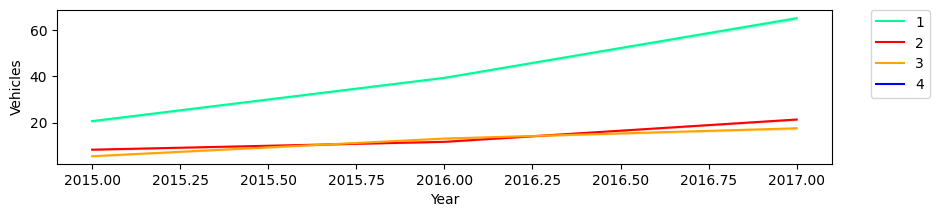

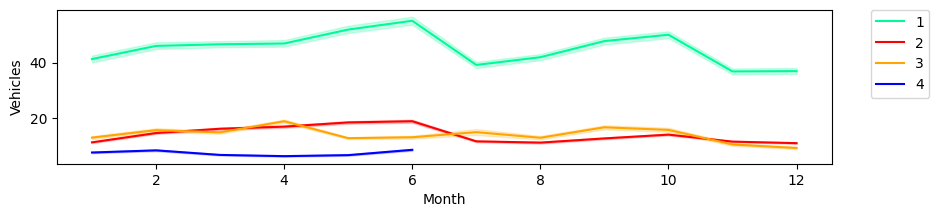

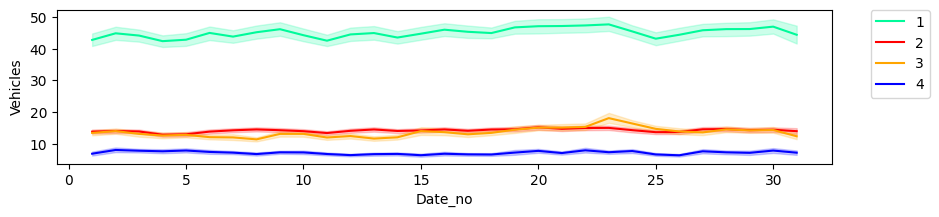

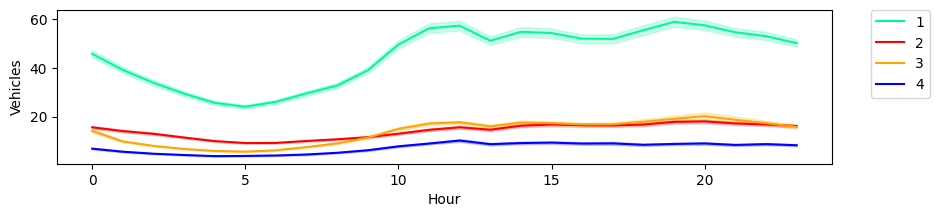

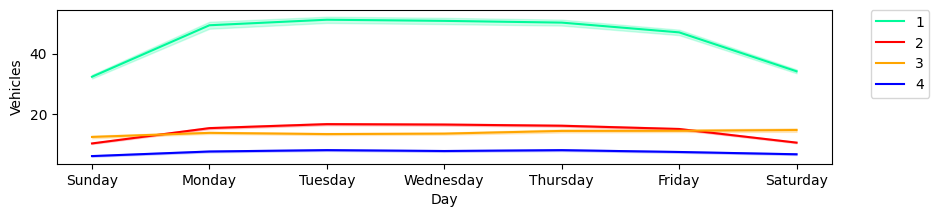

In [ ]:
#Let's plot the Timeseries
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2))
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 0, 'Date')

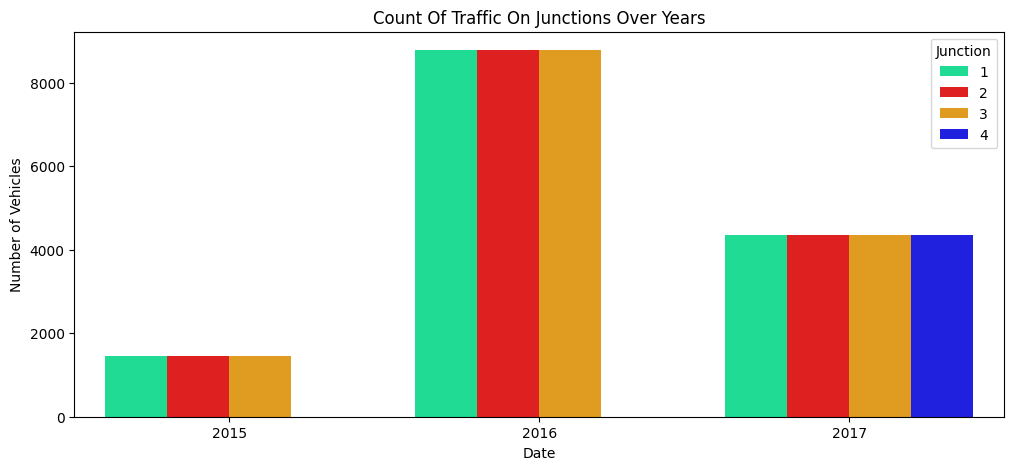

In [ ]:
plt.figure(figsize=(12,5))
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

<Axes: >

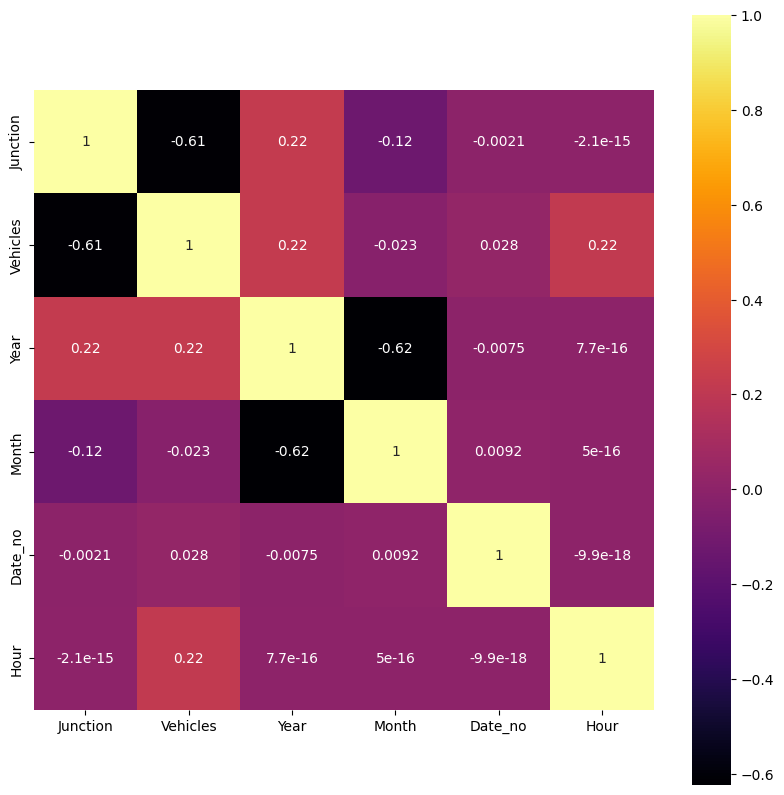

In [ ]:
corrmat = df.corr()
plt.subplots(figsize=(10,10))
sns.heatmap(corrmat,cmap= "inferno",annot=True,square=True, )

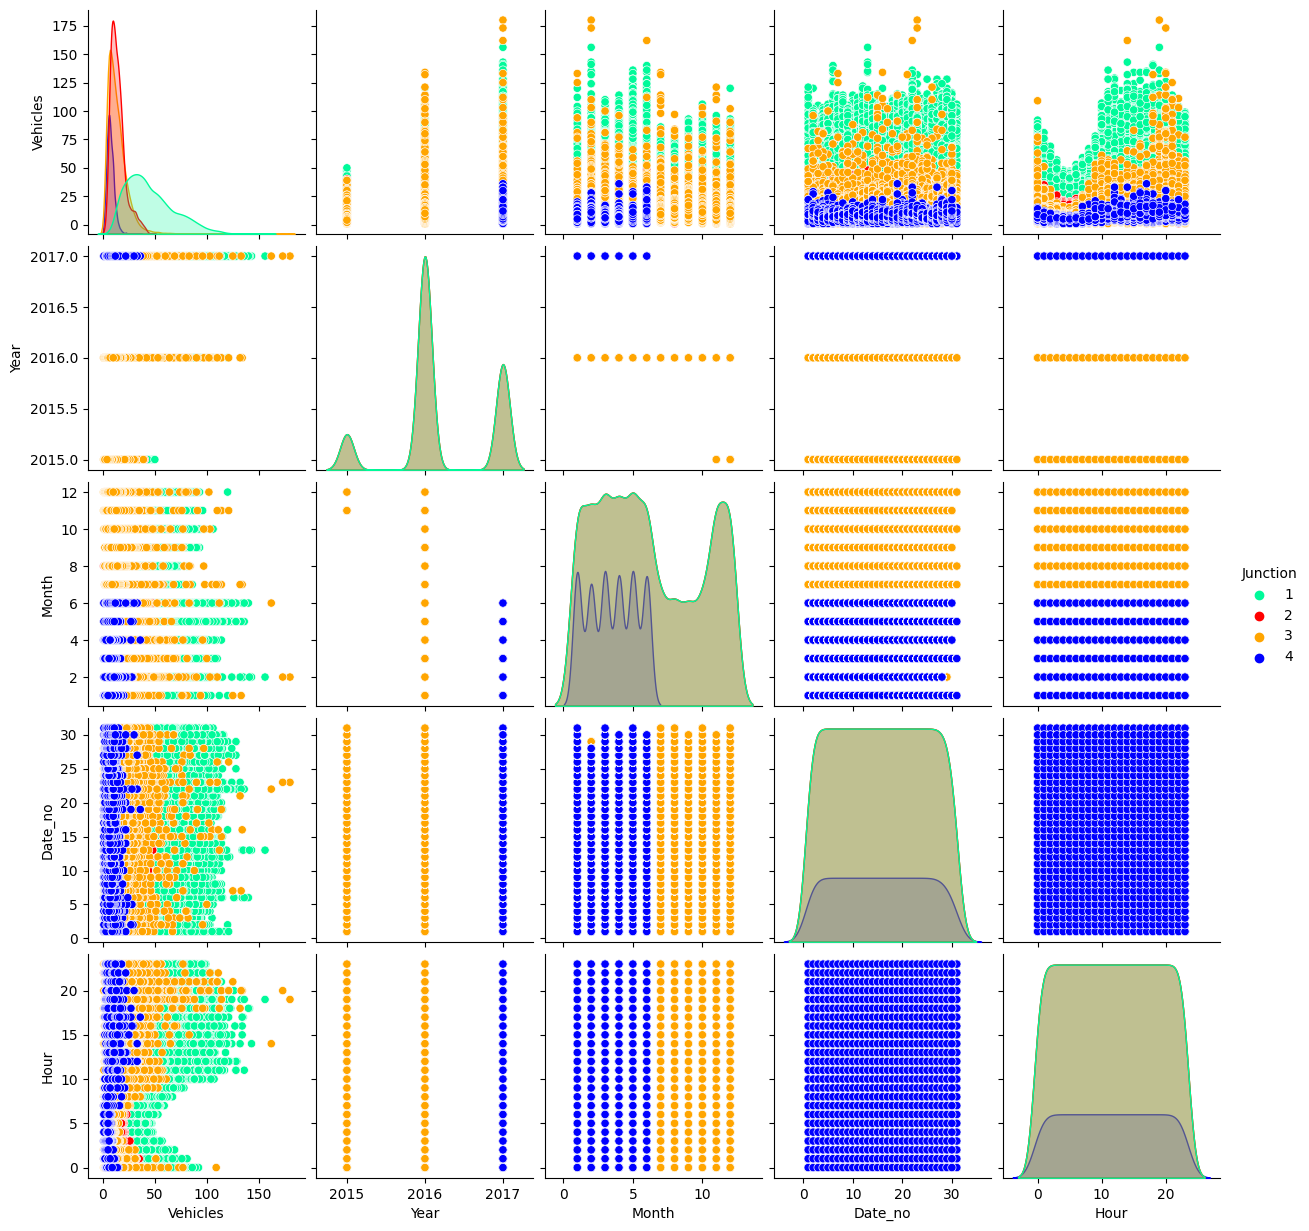

In [ ]:
sns.pairplot(data=df, hue= "Junction",palette=colors)

**Data Transformation And Preprocessing**

In [ ]:
#Pivoting data from junction
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

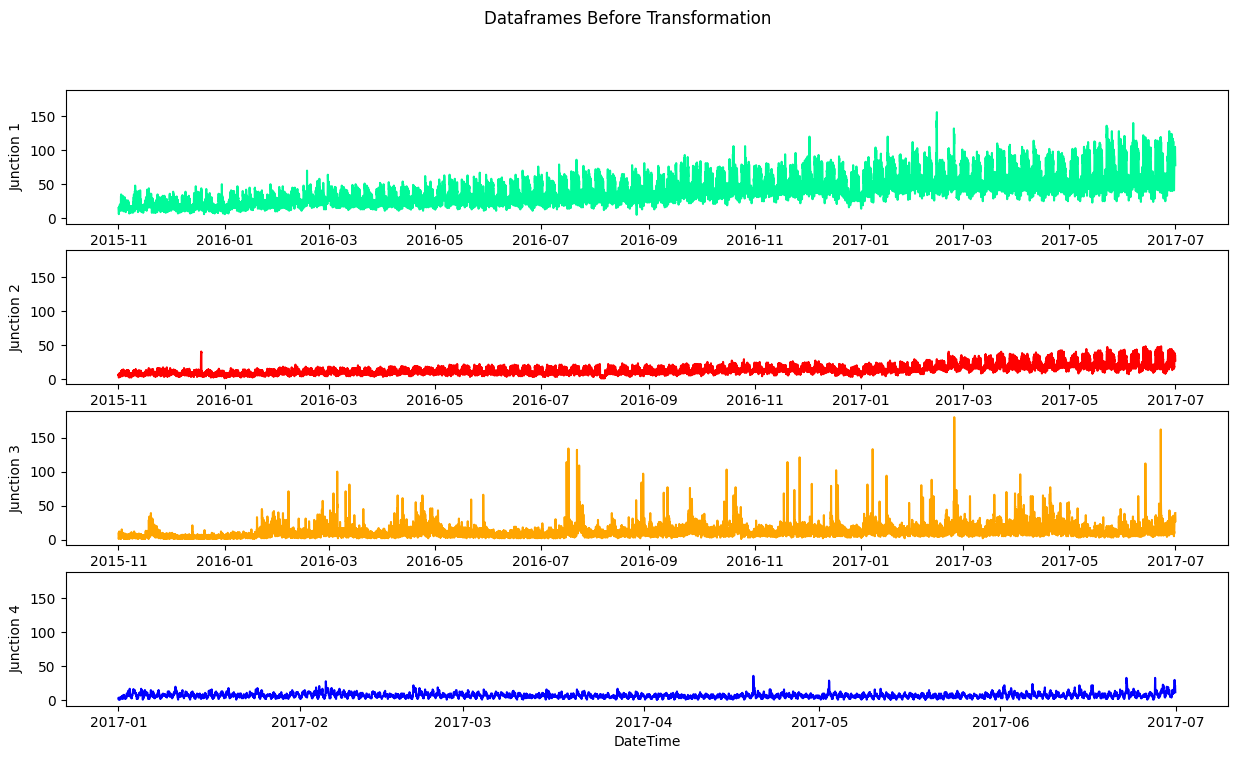

In [ ]:
#Creating new sets
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)

#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8), sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")


#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")

**Transforming**

In [ ]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [ ]:
#Normalizing and Differencing to make the series stationary
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

**Plots of Transformed Dataframe**

In [ ]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")


**Stationary Check**

In [ ]:
#Stationary Check for the time series Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary")


#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]]
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415337
p-value: 4.79853987639816e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.795891026940065
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832316
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.979092563052276
p-value: 2.778787532595421e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


**Splitting the dataset**

In [ ]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len]
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

**Model Building**

In [ ]:
#Model for the prediction
def GRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)
    #callback delta 0.01 may interrupt the learning, could eliminate this step, but meh!

    #The GRU model
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    #model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    #model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    #Compiling the model
    model.compile(optimizer=SGD(decay=1e-7, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU

#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5))
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

In [ ]:
#Predictions For First Junction
PredJ1 = GRU_model(X_trainJ1,y_trainJ1,X_testJ1)

Epoch 1/50
87/87 [==============================] - ETA: 0s - loss: 0.0749

87/87 [==============================] - 40s 343ms/step - loss: 0.0749
Epoch 2/50
87/87 [==============================] - ETA: 0s - loss: 0.0651

87/87 [==============================] - 31s 359ms/step - loss: 0.0651
Epoch 3/50
87/87 [==============================] - ETA: 0s - loss: 0.0641

87/87 [==============================] - 30s 345ms/step - loss: 0.0641
Epoch 4/50
87/87 [==============================] - ETA: 0s - loss: 0.0622

87/87 [==============================] - 31s 357ms/step - loss: 0.0622
Epoch 5/50
87/87 [==============================] - ETA: 0s - loss: 0.0617

87/87 [==============================] - 30s 342ms/step - loss: 0.0617
Epoch 6/50
87/87 [==============================] - ETA: 0s - loss: 0.0602

87/87 [==============================] - 30s 349ms/step - loss: 0.0602
Epoch 7/50
87/87 [==============================] - ETA: 0s - loss: 0.0592

87/87 [==============================] - 31s 360ms/step - loss: 0.0592
Epoch 8/50
87/87 [==============================] - ETA: 0s - loss: 0.0581

87/87 [==============================] - 30s 341ms/step - loss: 0.0581
Epoch 9/50
87/87 [==============================] - ETA: 0s - loss: 0.0581

87/87 [==============================] - 31s 358ms/step - loss: 0.0581
Epoch 10/50
87/87 [==============================] - ETA: 0s - loss: 0.0569

87/87 [==============================] - 31s 349ms/step - loss: 0.0569
Epoch 11/50
87/87 [==============================] - ETA: 0s - loss: 0.0560

87/87 [==============================] - 30s 346ms/step - loss: 0.0560
Epoch 12/50
87/87 [==============================] - ETA: 0s - loss: 0.0557

87/87 [==============================] - 31s 358ms/step - loss: 0.0557
Epoch 13/50
87/87 [==============================] - ETA: 0s - loss: 0.0548

87/87 [==============================] - 30s 349ms/step - loss: 0.0548
Epoch 14/50
87/87 [==============================] - ETA: 0s - loss: 0.0547

87/87 [==============================] - 32s 363ms/step - loss: 0.0547
Epoch 15/50
87/87 [==============================] - ETA: 0s - loss: 0.0549

87/87 [==============================] - 30s 346ms/step - loss: 0.0549
Epoch 16/50
87/87 [==============================] - ETA: 0s - loss: 0.0545

87/87 [==============================] - 31s 355ms/step - loss: 0.0545
Epoch 17/50
87/87 [==============================] - ETA: 0s - loss: 0.0537

87/87 [==============================] - 31s 350ms/step - loss: 0.0537
Epoch 18/50
87/87 [==============================] - ETA: 0s - loss: 0.0531

87/87 [==============================] - 30s 345ms/step - loss: 0.0531
Epoch 19/50
87/87 [==============================] - ETA: 0s - loss: 0.0526

87/87 [==============================] - 32s 367ms/step - loss: 0.0526
Epoch 20/50
87/87 [==============================] - ETA: 0s - loss: 0.0527

87/87 [==============================] - 30s 347ms/step - loss: 0.0527
Epoch 21/50
87/87 [==============================] - ETA: 0s - loss: 0.0519

87/87 [==============================] - 31s 356ms/step - loss: 0.0519
Epoch 22/50
87/87 [==============================] - ETA: 0s - loss: 0.0517

87/87 [==============================] - 31s 351ms/step - loss: 0.0517
Epoch 23/50
87/87 [==============================] - ETA: 0s - loss: 0.0510

87/87 [==============================] - 30s 348ms/step - loss: 0.0510
Epoch 24/50
87/87 [==============================] - ETA: 0s - loss: 0.0511

87/87 [==============================] - 31s 358ms/step - loss: 0.0511
Epoch 25/50
87/87 [==============================] - ETA: 0s - loss: 0.0507

87/87 [==============================] - 30s 349ms/step - loss: 0.0507
Epoch 26/50
87/87 [==============================] - ETA: 0s - loss: 0.0507

87/87 [==============================] - 32s 363ms/step - loss: 0.0507
Epoch 27/50
87/87 [==============================] - ETA: 0s - loss: 0.0505

87/87 [==============================] - 30s 346ms/step - loss: 0.0505
Epoch 28/50
87/87 [==============================] - ETA: 0s - loss: 0.0508

87/87 [==============================] - 31s 357ms/step - loss: 0.0508
Epoch 29/50
87/87 [==============================] - ETA: 0s - loss: 0.0504

87/87 [==============================] - 30s 344ms/step - loss: 0.0504
Epoch 30/50
87/87 [==============================] - ETA: 0s - loss: 0.0501

87/87 [==============================] - 30s 347ms/step - loss: 0.0501
Epoch 31/50
87/87 [==============================] - ETA: 0s - loss: 0.0498

87/87 [==============================] - 31s 360ms/step - loss: 0.0498
Epoch 32/50
87/87 [==============================] - ETA: 0s - loss: 0.0496

87/87 [==============================] - 30s 348ms/step - loss: 0.0496
Epoch 33/50
87/87 [==============================] - ETA: 0s - loss: 0.0492

87/87 [==============================] - 31s 358ms/step - loss: 0.0492
Epoch 34/50
87/87 [==============================] - ETA: 0s - loss: 0.0498

87/87 [==============================] - 30s 343ms/step - loss: 0.0498
Epoch 35/50
87/87 [==============================] - ETA: 0s - loss: 0.0495

87/87 [==============================] - 30s 349ms/step - loss: 0.0495
Epoch 36/50
87/87 [==============================] - ETA: 0s - loss: 0.0495

87/87 [==============================] - 31s 356ms/step - loss: 0.0495
Epoch 37/50
87/87 [==============================] - ETA: 0s - loss: 0.0492

87/87 [==============================] - 30s 348ms/step - loss: 0.0492
Epoch 38/50
87/87 [==============================] - ETA: 0s - loss: 0.0486

87/87 [==============================] - 31s 361ms/step - loss: 0.0486
Epoch 39/50
87/87 [==============================] - ETA: 0s - loss: 0.0493

87/87 [==============================] - 30s 350ms/step - loss: 0.0493
Epoch 40/50
87/87 [==============================] - ETA: 0s - loss: 0.0491

87/87 [==============================] - 31s 355ms/step - loss: 0.0491
Epoch 41/50
87/87 [==============================] - ETA: 0s - loss: 0.0490

87/87 [==============================] - 31s 352ms/step - loss: 0.0490
Epoch 42/50
87/87 [==============================] - ETA: 0s - loss: 0.0488

87/87 [==============================] - 29s 339ms/step - loss: 0.0488
Epoch 43/50
87/87 [==============================] - ETA: 0s - loss: 0.0487

87/87 [==============================] - 32s 365ms/step - loss: 0.0487
Epoch 44/50
87/87 [==============================] - ETA: 0s - loss: 0.0487

87/87 [==============================] - 31s 353ms/step - loss: 0.0487
Epoch 45/50
87/87 [==============================] - ETA: 0s - loss: 0.0479

87/87 [==============================] - 31s 358ms/step - loss: 0.0479
Epoch 46/50
87/87 [==============================] - ETA: 0s - loss: 0.0480

87/87 [==============================] - 30s 341ms/step - loss: 0.0480
Epoch 47/50
87/87 [==============================] - ETA: 0s - loss: 0.0480

87/87 [==============================] - 30s 343ms/step - loss: 0.0480
Epoch 48/50
87/87 [==============================] - ETA: 0s - loss: 0.0482

87/87 [==============================] - 32s 363ms/step - loss: 0.0482
Epoch 49/50
87/87 [==============================] - ETA: 0s - loss: 0.0491

87/87 [==============================] - 30s 346ms/step - loss: 0.0491
Epoch 50/50
87/87 [==============================] - ETA: 0s - loss: 0.0476

45/45 [==============================] - 4s 41ms/step


**Fitting The Model**

In [ ]:
#Results for J1
RMSE_J1=RMSE_Value(y_testJ1,PredJ1)
PredictionsPlot(y_testJ1,PredJ1,0)

The root mean squared error is 0.24646989411943138.


In [ ]:
#Predictions For Second Junction
PredJ2 = GRU_model(X_trainJ2,y_trainJ2,X_testJ2)

Epoch 1/50
88/88 [==============================] - ETA: 0s - loss: 0.2301

88/88 [==============================] - 40s 341ms/step - loss: 0.2301
Epoch 2/50
88/88 [==============================] - ETA: 0s - loss: 0.2042

88/88 [==============================] - 30s 345ms/step - loss: 0.2042
Epoch 3/50
88/88 [==============================] - ETA: 0s - loss: 0.1972

88/88 [==============================] - 33s 374ms/step - loss: 0.1972
Epoch 4/50
88/88 [==============================] - ETA: 0s - loss: 0.1960

88/88 [==============================] - 30s 343ms/step - loss: 0.1960
Epoch 5/50
88/88 [==============================] - ETA: 0s - loss: 0.1938

88/88 [==============================] - 31s 354ms/step - loss: 0.1938
Epoch 6/50
88/88 [==============================] - ETA: 0s - loss: 0.1931

88/88 [==============================] - 31s 357ms/step - loss: 0.1931
Epoch 7/50
88/88 [==============================] - ETA: 0s - loss: 0.1911

88/88 [==============================] - 31s 356ms/step - loss: 0.1911
Epoch 8/50
88/88 [==============================] - ETA: 0s - loss: 0.1895

88/88 [==============================] - 30s 342ms/step - loss: 0.1895
Epoch 9/50
88/88 [==============================] - ETA: 0s - loss: 0.1891

88/88 [==============================] - 32s 362ms/step - loss: 0.1891
Epoch 10/50
88/88 [==============================] - ETA: 0s - loss: 0.1903

88/88 [==============================] - 30s 343ms/step - loss: 0.1903
Epoch 11/50
88/88 [==============================] - ETA: 0s - loss: 0.1889

88/88 [==============================] - 31s 353ms/step - loss: 0.1889
Epoch 12/50
88/88 [==============================] - ETA: 0s - loss: 0.1888

88/88 [==============================] - 31s 345ms/step - loss: 0.1888
Epoch 13/50
88/88 [==============================] - ETA: 0s - loss: 0.1884

88/88 [==============================] - 31s 351ms/step - loss: 0.1884
Epoch 14/50
88/88 [==============================] - ETA: 0s - loss: 0.1867

88/88 [==============================] - 31s 354ms/step - loss: 0.1867
Epoch 15/50
88/88 [==============================] - ETA: 0s - loss: 0.1860

88/88 [==============================] - 30s 346ms/step - loss: 0.1860
Epoch 16/50
88/88 [==============================] - ETA: 0s - loss: 0.1864

88/88 [==============================] - 32s 359ms/step - loss: 0.1864
Epoch 17/50
88/88 [==============================] - ETA: 0s - loss: 0.1859

88/88 [==============================] - 30s 344ms/step - loss: 0.1859
Epoch 18/50
88/88 [==============================] - ETA: 0s - loss: 0.1859

88/88 [==============================] - 32s 361ms/step - loss: 0.1859
Epoch 19/50
88/88 [==============================] - ETA: 0s - loss: 0.1846

88/88 [==============================] - 30s 344ms/step - loss: 0.1846
Epoch 20/50
88/88 [==============================] - ETA: 0s - loss: 0.1836

88/88 [==============================] - 30s 346ms/step - loss: 0.1836
Epoch 21/50
88/88 [==============================] - ETA: 0s - loss: 0.1844

88/88 [==============================] - 32s 356ms/step - loss: 0.1844
Epoch 22/50
88/88 [==============================] - ETA: 0s - loss: 0.1841

88/88 [==============================] - 31s 349ms/step - loss: 0.1841
Epoch 23/50
88/88 [==============================] - ETA: 0s - loss: 0.1860

88/88 [==============================] - 31s 356ms/step - loss: 0.1860
Epoch 24/50
88/88 [==============================] - ETA: 0s - loss: 0.1858

88/88 [==============================] - 31s 348ms/step - loss: 0.1858
Epoch 25/50
88/88 [==============================] - ETA: 0s - loss: 0.1846

88/88 [==============================] - 32s 358ms/step - loss: 0.1846
Epoch 26/50
88/88 [==============================] - ETA: 0s - loss: 0.1832

88/88 [==============================] - 30s 343ms/step - loss: 0.1832
Epoch 27/50
88/88 [==============================] - ETA: 0s - loss: 0.1838

88/88 [==============================] - 30s 346ms/step - loss: 0.1838
Epoch 28/50
88/88 [==============================] - ETA: 0s - loss: 0.1831

88/88 [==============================] - 31s 346ms/step - loss: 0.1831
Epoch 29/50
88/88 [==============================] - ETA: 0s - loss: 0.1848

88/88 [==============================] - 31s 347ms/step - loss: 0.1848
Epoch 30/50
88/88 [==============================] - ETA: 0s - loss: 0.1819

88/88 [==============================] - 32s 359ms/step - loss: 0.1819
Epoch 31/50
88/88 [==============================] - ETA: 0s - loss: 0.1835

88/88 [==============================] - 30s 342ms/step - loss: 0.1835
Epoch 32/50
88/88 [==============================] - ETA: 0s - loss: 0.1822

88/88 [==============================] - 32s 364ms/step - loss: 0.1822
Epoch 33/50
88/88 [==============================] - ETA: 0s - loss: 0.1833

88/88 [==============================] - 31s 349ms/step - loss: 0.1833
Epoch 34/50
88/88 [==============================] - ETA: 0s - loss: 0.1838

88/88 [==============================] - 32s 361ms/step - loss: 0.1838
Epoch 35/50
88/88 [==============================] - ETA: 0s - loss: 0.1831

88/88 [==============================] - 30s 342ms/step - loss: 0.1831
Epoch 36/50
88/88 [==============================] - ETA: 0s - loss: 0.1832

88/88 [==============================] - 30s 341ms/step - loss: 0.1832
Epoch 37/50
88/88 [==============================] - ETA: 0s - loss: 0.1819

88/88 [==============================] - 32s 366ms/step - loss: 0.1819
Epoch 38/50
88/88 [==============================] - ETA: 0s - loss: 0.1834

88/88 [==============================] - 30s 343ms/step - loss: 0.1834
Epoch 39/50
88/88 [==============================] - ETA: 0s - loss: 0.1821

88/88 [==============================] - 32s 367ms/step - loss: 0.1821
Epoch 40/50
88/88 [==============================] - ETA: 0s - loss: 0.1823

88/88 [==============================] - 31s 349ms/step - loss: 0.1823
Epoch 41/50
88/88 [==============================] - ETA: 0s - loss: 0.1827

88/88 [==============================] - 32s 361ms/step - loss: 0.1827
Epoch 42/50
88/88 [==============================] - ETA: 0s - loss: 0.1823

88/88 [==============================] - 30s 345ms/step - loss: 0.1823
Epoch 43/50
88/88 [==============================] - ETA: 0s - loss: 0.1821

88/88 [==============================] - 32s 361ms/step - loss: 0.1821
Epoch 44/50
88/88 [==============================] - ETA: 0s - loss: 0.1819

88/88 [==============================] - 30s 346ms/step - loss: 0.1819
Epoch 45/50
88/88 [==============================] - ETA: 0s - loss: 0.1808

88/88 [==============================] - 31s 352ms/step - loss: 0.1808
Epoch 46/50
88/88 [==============================] - ETA: 0s - loss: 0.1829

88/88 [==============================] - 31s 345ms/step - loss: 0.1829
Epoch 47/50
88/88 [==============================] - ETA: 0s - loss: 0.1821

88/88 [==============================] - 31s 347ms/step - loss: 0.1821
Epoch 48/50
88/88 [==============================] - ETA: 0s - loss: 0.1819

88/88 [==============================] - 32s 366ms/step - loss: 0.1819
Epoch 49/50
88/88 [==============================] - ETA: 0s - loss: 0.1827

88/88 [==============================] - 30s 344ms/step - loss: 0.1827
Epoch 50/50
88/88 [==============================] - ETA: 0s - loss: 0.1819

45/45 [==============================] - 4s 39ms/step


The root mean squared error is 0.5596310882257831.


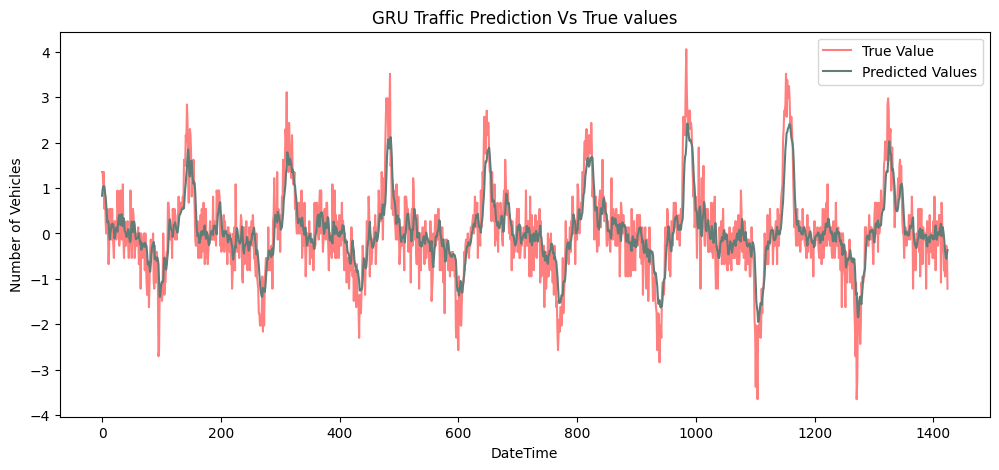

In [ ]:
#Results for J2
RMSE_J2=RMSE_Value(y_testJ2,PredJ2)
PredictionsPlot(y_testJ2,PredJ2,1)

In [ ]:
#Predictions For Third Junction
PredJ3 = GRU_model(X_trainJ3,y_trainJ3,X_testJ3)

Epoch 1/50
88/88 [==============================] - ETA: 0s - loss: 0.3030

88/88 [==============================] - 41s 350ms/step - loss: 0.3030
Epoch 2/50
88/88 [==============================] - ETA: 0s - loss: 0.2973

88/88 [==============================] - 31s 357ms/step - loss: 0.2973
Epoch 3/50
88/88 [==============================] - ETA: 0s - loss: 0.2915

88/88 [==============================] - 32s 358ms/step - loss: 0.2915
Epoch 4/50
88/88 [==============================] - ETA: 0s - loss: 0.2894

88/88 [==============================] - 31s 352ms/step - loss: 0.2894
Epoch 5/50
88/88 [==============================] - ETA: 0s - loss: 0.2893

88/88 [==============================] - 32s 363ms/step - loss: 0.2893
Epoch 6/50
88/88 [==============================] - ETA: 0s - loss: 0.2900

88/88 [==============================] - 31s 353ms/step - loss: 0.2900
Epoch 7/50
88/88 [==============================] - ETA: 0s - loss: 0.2877

88/88 [==============================] - 32s 359ms/step - loss: 0.2877
Epoch 8/50
88/88 [==============================] - ETA: 0s - loss: 0.2856

88/88 [==============================] - 31s 357ms/step - loss: 0.2856
Epoch 9/50
88/88 [==============================] - ETA: 0s - loss: 0.2863

88/88 [==============================] - 31s 355ms/step - loss: 0.2863
Epoch 10/50
88/88 [==============================] - ETA: 0s - loss: 0.2852

88/88 [==============================] - 31s 349ms/step - loss: 0.2852
Epoch 11/50
88/88 [==============================] - ETA: 0s - loss: 0.2853

88/88 [==============================] - 32s 364ms/step - loss: 0.2853
Epoch 12/50
88/88 [==============================] - ETA: 0s - loss: 0.2829

88/88 [==============================] - 31s 356ms/step - loss: 0.2829
Epoch 13/50
88/88 [==============================] - ETA: 0s - loss: 0.2861

88/88 [==============================] - 32s 365ms/step - loss: 0.2861
Epoch 14/50
88/88 [==============================] - ETA: 0s - loss: 0.2828

88/88 [==============================] - 31s 352ms/step - loss: 0.2828
Epoch 15/50
88/88 [==============================] - ETA: 0s - loss: 0.2795

88/88 [==============================] - 32s 364ms/step - loss: 0.2795
Epoch 16/50
88/88 [==============================] - ETA: 0s - loss: 0.2787

88/88 [==============================] - 31s 354ms/step - loss: 0.2787
Epoch 17/50
88/88 [==============================] - ETA: 0s - loss: 0.2794

88/88 [==============================] - 32s 367ms/step - loss: 0.2794
Epoch 18/50
88/88 [==============================] - ETA: 0s - loss: 0.2762

88/88 [==============================] - 31s 353ms/step - loss: 0.2762
Epoch 19/50
88/88 [==============================] - ETA: 0s - loss: 0.2742

88/88 [==============================] - 32s 365ms/step - loss: 0.2742
Epoch 20/50
88/88 [==============================] - ETA: 0s - loss: 0.2739

88/88 [==============================] - 31s 352ms/step - loss: 0.2739
Epoch 21/50
88/88 [==============================] - ETA: 0s - loss: 0.2726

88/88 [==============================] - 32s 366ms/step - loss: 0.2726
Epoch 22/50
88/88 [==============================] - ETA: 0s - loss: 0.2756

88/88 [==============================] - 31s 354ms/step - loss: 0.2756
Epoch 23/50
88/88 [==============================] - ETA: 0s - loss: 0.2770

88/88 [==============================] - 32s 367ms/step - loss: 0.2770
Epoch 24/50
88/88 [==============================] - ETA: 0s - loss: 0.2756

88/88 [==============================] - 31s 357ms/step - loss: 0.2756
Epoch 25/50
88/88 [==============================] - ETA: 0s - loss: 0.2709

88/88 [==============================] - 32s 364ms/step - loss: 0.2709
Epoch 26/50
88/88 [==============================] - ETA: 0s - loss: 0.2741

88/88 [==============================] - 31s 350ms/step - loss: 0.2741
Epoch 27/50
88/88 [==============================] - ETA: 0s - loss: 0.2737

88/88 [==============================] - 32s 366ms/step - loss: 0.2737
Epoch 28/50
88/88 [==============================] - ETA: 0s - loss: 0.2713

88/88 [==============================] - 31s 352ms/step - loss: 0.2713
Epoch 29/50
88/88 [==============================] - ETA: 0s - loss: 0.2720

88/88 [==============================] - 32s 364ms/step - loss: 0.2720
Epoch 30/50
88/88 [==============================] - ETA: 0s - loss: 0.2700

88/88 [==============================] - 31s 353ms/step - loss: 0.2700
Epoch 31/50
88/88 [==============================] - ETA: 0s - loss: 0.2679

88/88 [==============================] - 32s 366ms/step - loss: 0.2679
Epoch 32/50
88/88 [==============================] - ETA: 0s - loss: 0.2709

88/88 [==============================] - 31s 355ms/step - loss: 0.2709
Epoch 33/50
88/88 [==============================] - ETA: 0s - loss: 0.2701

88/88 [==============================] - 32s 363ms/step - loss: 0.2701
Epoch 34/50
88/88 [==============================] - ETA: 0s - loss: 0.2687

88/88 [==============================] - 31s 357ms/step - loss: 0.2687
Epoch 35/50
88/88 [==============================] - ETA: 0s - loss: 0.2697

88/88 [==============================] - 32s 366ms/step - loss: 0.2697
Epoch 36/50
88/88 [==============================] - ETA: 0s - loss: 0.2657

88/88 [==============================] - 31s 355ms/step - loss: 0.2657
Epoch 37/50
88/88 [==============================] - ETA: 0s - loss: 0.2663

88/88 [==============================] - 32s 368ms/step - loss: 0.2663
Epoch 38/50
88/88 [==============================] - ETA: 0s - loss: 0.2660

88/88 [==============================] - 31s 352ms/step - loss: 0.2660
Epoch 39/50
88/88 [==============================] - ETA: 0s - loss: 0.2654

88/88 [==============================] - 32s 363ms/step - loss: 0.2654
Epoch 40/50
88/88 [==============================] - ETA: 0s - loss: 0.2668

88/88 [==============================] - 30s 346ms/step - loss: 0.2668
Epoch 41/50
88/88 [==============================] - ETA: 0s - loss: 0.2650

88/88 [==============================] - 32s 364ms/step - loss: 0.2650
Epoch 42/50
88/88 [==============================] - ETA: 0s - loss: 0.2650

88/88 [==============================] - 31s 350ms/step - loss: 0.2650
Epoch 43/50
88/88 [==============================] - ETA: 0s - loss: 0.2655

88/88 [==============================] - 32s 365ms/step - loss: 0.2655
Epoch 44/50
88/88 [==============================] - ETA: 0s - loss: 0.2645

88/88 [==============================] - 31s 354ms/step - loss: 0.2645
Epoch 45/50
88/88 [==============================] - ETA: 0s - loss: 0.2661

88/88 [==============================] - 32s 365ms/step - loss: 0.2661
Epoch 46/50
88/88 [==============================] - ETA: 0s - loss: 0.2644

88/88 [==============================] - 31s 357ms/step - loss: 0.2644
Epoch 47/50
88/88 [==============================] - ETA: 0s - loss: 0.2650

88/88 [==============================] - 32s 365ms/step - loss: 0.2650
Epoch 48/50
88/88 [==============================] - ETA: 0s - loss: 0.2636

88/88 [==============================] - 31s 353ms/step - loss: 0.2636
Epoch 49/50
88/88 [==============================] - ETA: 0s - loss: 0.2632

88/88 [==============================] - 32s 362ms/step - loss: 0.2632
Epoch 50/50
88/88 [==============================] - ETA: 0s - loss: 0.2629

45/45 [==============================] - 5s 56ms/step


The root mean squared error is 0.6060712455300781.


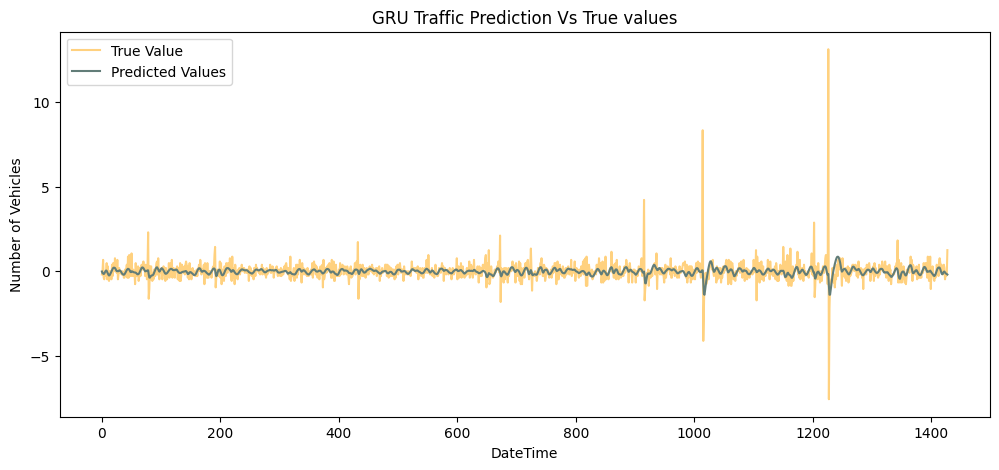

In [ ]:
#Results for J3
RMSE_J3=RMSE_Value(y_testJ3,PredJ3)
PredictionsPlot(y_testJ3,PredJ3,2)

In [ ]:
#Predictions For Forth Junction
PredJ4 = GRU_model(X_trainJ4,y_trainJ4,X_testJ4)

Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 0.6879

26/26 [==============================] - 21s 392ms/step - loss: 0.6879
Epoch 2/50
26/26 [==============================] - ETA: 0s - loss: 0.6859

26/26 [==============================] - 10s 399ms/step - loss: 0.6859
Epoch 3/50
26/26 [==============================] - ETA: 0s - loss: 0.6886

26/26 [==============================] - 10s 393ms/step - loss: 0.6886
Epoch 4/50
26/26 [==============================] - ETA: 0s - loss: 0.6881

26/26 [==============================] - 9s 359ms/step - loss: 0.6881
Epoch 5/50
26/26 [==============================] - ETA: 0s - loss: 0.6814

26/26 [==============================] - 10s 370ms/step - loss: 0.6814
Epoch 6/50
26/26 [==============================] - ETA: 0s - loss: 0.6801

26/26 [==============================] - 10s 398ms/step - loss: 0.6801
Epoch 7/50
26/26 [==============================] - ETA: 0s - loss: 0.6861

26/26 [==============================] - 10s 388ms/step - loss: 0.6861
Epoch 8/50
26/26 [==============================] - ETA: 0s - loss: 0.6796

26/26 [==============================] - 10s 389ms/step - loss: 0.6796
Epoch 9/50
26/26 [==============================] - ETA: 0s - loss: 0.6816

26/26 [==============================] - 9s 347ms/step - loss: 0.6816
Epoch 10/50
26/26 [==============================] - ETA: 0s - loss: 0.6794

26/26 [==============================] - 10s 394ms/step - loss: 0.6794
Epoch 11/50
26/26 [==============================] - ETA: 0s - loss: 0.6839

26/26 [==============================] - 10s 393ms/step - loss: 0.6839
Epoch 12/50
26/26 [==============================] - ETA: 0s - loss: 0.6827

26/26 [==============================] - 10s 388ms/step - loss: 0.6827
Epoch 13/50
26/26 [==============================] - ETA: 0s - loss: 0.6798

26/26 [==============================] - 9s 365ms/step - loss: 0.6798
Epoch 14/50
26/26 [==============================] - ETA: 0s - loss: 0.6763

26/26 [==============================] - 10s 364ms/step - loss: 0.6763
Epoch 15/50
26/26 [==============================] - ETA: 0s - loss: 0.6759

26/26 [==============================] - 10s 390ms/step - loss: 0.6759
Epoch 16/50
26/26 [==============================] - ETA: 0s - loss: 0.6782

26/26 [==============================] - 10s 396ms/step - loss: 0.6782
Epoch 17/50
26/26 [==============================] - ETA: 0s - loss: 0.6773

26/26 [==============================] - 10s 388ms/step - loss: 0.6773
Epoch 18/50
26/26 [==============================] - ETA: 0s - loss: 0.6839

26/26 [==============================] - 9s 350ms/step - loss: 0.6839
Epoch 19/50
26/26 [==============================] - ETA: 0s - loss: 0.6801

26/26 [==============================] - 10s 395ms/step - loss: 0.6801
Epoch 20/50
26/26 [==============================] - ETA: 0s - loss: 0.6701

26/26 [==============================] - 10s 385ms/step - loss: 0.6701
Epoch 21/50
26/26 [==============================] - ETA: 0s - loss: 0.6696

26/26 [==============================] - 10s 390ms/step - loss: 0.6696
Epoch 22/50
26/26 [==============================] - ETA: 0s - loss: 0.6689

26/26 [==============================] - 10s 382ms/step - loss: 0.6689
Epoch 23/50
26/26 [==============================] - ETA: 0s - loss: 0.6749

26/26 [==============================] - 9s 350ms/step - loss: 0.6749
Epoch 24/50
26/26 [==============================] - ETA: 0s - loss: 0.6675

26/26 [==============================] - 10s 397ms/step - loss: 0.6675
Epoch 25/50
26/26 [==============================] - ETA: 0s - loss: 0.6738

26/26 [==============================] - 10s 397ms/step - loss: 0.6738
Epoch 26/50
26/26 [==============================] - ETA: 0s - loss: 0.6657

26/26 [==============================] - 10s 394ms/step - loss: 0.6657
Epoch 27/50
26/26 [==============================] - ETA: 0s - loss: 0.6633

26/26 [==============================] - 10s 368ms/step - loss: 0.6633
Epoch 28/50
26/26 [==============================] - ETA: 0s - loss: 0.6562

26/26 [==============================] - 10s 367ms/step - loss: 0.6562
Epoch 29/50
26/26 [==============================] - ETA: 0s - loss: 0.6469

26/26 [==============================] - 10s 392ms/step - loss: 0.6469
Epoch 30/50
26/26 [==============================] - ETA: 0s - loss: 0.6412

26/26 [==============================] - 10s 387ms/step - loss: 0.6412
Epoch 31/50
26/26 [==============================] - ETA: 0s - loss: 0.6424

26/26 [==============================] - 10s 390ms/step - loss: 0.6424
Epoch 32/50
26/26 [==============================] - ETA: 0s - loss: 0.6375

26/26 [==============================] - 9s 357ms/step - loss: 0.6375
Epoch 33/50
26/26 [==============================] - ETA: 0s - loss: 0.6341

26/26 [==============================] - 10s 397ms/step - loss: 0.6341
Epoch 34/50
26/26 [==============================] - ETA: 0s - loss: 0.6198

26/26 [==============================] - 10s 395ms/step - loss: 0.6198
Epoch 35/50
26/26 [==============================] - ETA: 0s - loss: 0.6257

26/26 [==============================] - 10s 386ms/step - loss: 0.6257
Epoch 36/50
26/26 [==============================] - ETA: 0s - loss: 0.6103

26/26 [==============================] - 10s 385ms/step - loss: 0.6103
Epoch 37/50
26/26 [==============================] - ETA: 0s - loss: 0.5956

26/26 [==============================] - 9s 348ms/step - loss: 0.5956
Epoch 38/50
26/26 [==============================] - ETA: 0s - loss: 0.5937

26/26 [==============================] - 10s 397ms/step - loss: 0.5937
Epoch 39/50
26/26 [==============================] - ETA: 0s - loss: 0.6020

26/26 [==============================] - 10s 393ms/step - loss: 0.6020
Epoch 40/50
26/26 [==============================] - ETA: 0s - loss: 0.5932

26/26 [==============================] - 10s 401ms/step - loss: 0.5932
Epoch 41/50
26/26 [==============================] - ETA: 0s - loss: 0.5781

26/26 [==============================] - 10s 379ms/step - loss: 0.5781
Epoch 42/50
26/26 [==============================] - ETA: 0s - loss: 0.5669

26/26 [==============================] - 9s 351ms/step - loss: 0.5669
Epoch 43/50
26/26 [==============================] - ETA: 0s - loss: 0.5440

26/26 [==============================] - 10s 396ms/step - loss: 0.5440
Epoch 44/50
26/26 [==============================] - ETA: 0s - loss: 0.5510

26/26 [==============================] - 10s 385ms/step - loss: 0.5510
Epoch 45/50
26/26 [==============================] - ETA: 0s - loss: 0.5373

26/26 [==============================] - 10s 385ms/step - loss: 0.5373
Epoch 46/50
26/26 [==============================] - ETA: 0s - loss: 0.5712

26/26 [==============================] - 9s 349ms/step - loss: 0.5712
Epoch 47/50
26/26 [==============================] - ETA: 0s - loss: 0.5527

26/26 [==============================] - 10s 383ms/step - loss: 0.5527
Epoch 48/50
26/26 [==============================] - ETA: 0s - loss: 0.5238

26/26 [==============================] - 10s 390ms/step - loss: 0.5238
Epoch 49/50
26/26 [==============================] - ETA: 0s - loss: 0.5318

26/26 [==============================] - 10s 392ms/step - loss: 0.5318
Epoch 50/50
26/26 [==============================] - ETA: 0s - loss: 0.5198

13/13 [==============================] - 2s 46ms/step


The root mean squared error is 0.9930907817506894.


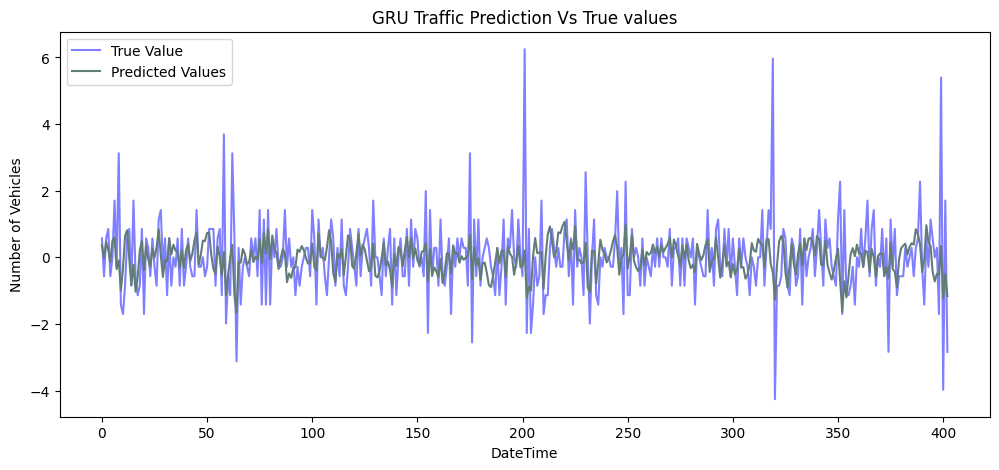

In [ ]:
#Results for J4
RMSE_J4=RMSE_Value(y_testJ4,PredJ4)
PredictionsPlot(y_testJ4,PredJ4,3)

In [ ]:
data = {'Junction': ['Junction1', 'Junction2', 'Junction3', 'Junction4'],
        'RMSE': [RMSE_J1,RMSE_J2,RMSE_J3,RMSE_J4]}

df = pd.DataFrame(data)
print(df)

    Junction      RMSE
0  Junction1  0.246470
1  Junction2  0.559631
2  Junction3  0.606071
3  Junction4  0.993091


**Inversing The Transformation Of Data**

In [ ]:
# Functions to inverse transforms and Plot comparitive plots
# invert differenced forecast
def inverse_difference(last_ob, value):
    inversed = value + last_ob
    return inversed
#Plotting the comparison
def Sub_Plots2(df_1, df_2,title,m):
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True)
    fig.suptitle(title)

    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[m])
    axes[0].set(ylabel ="Prediction")

    pl_2=sns.lineplot(ax=axes[1],data=df_2["Vehicles"],color="#627D78")
    axes[1].set(ylabel ="Orignal")

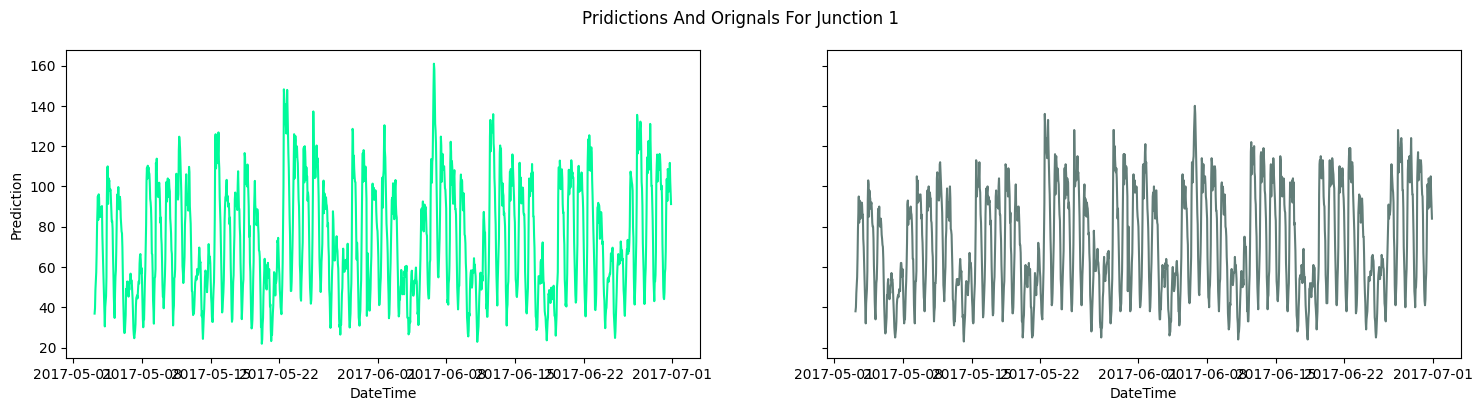

In [ ]:
# invert the differenced forecast for Junction 1
recover1 = df_N1.Norm[-1412:-1].to_frame()
recover1["Pred"]= PredJ1
Transform_reverssed_J1 = inverse_difference(recover1.Norm, recover1.Pred).to_frame()
Transform_reverssed_J1.columns = ["Pred_Normed"]
#Invert the normalizeation J1
Final_J1_Pred = (Transform_reverssed_J1.values* std_J1) + av_J1
Transform_reverssed_J1["Pred_Final"] =Final_J1_Pred
#Plotting the Predictions with orignals
Sub_Plots2(Transform_reverssed_J1["Pred_Final"], df_1[-1412:-1],"Pridictions And Orignals For Junction 1", 0)

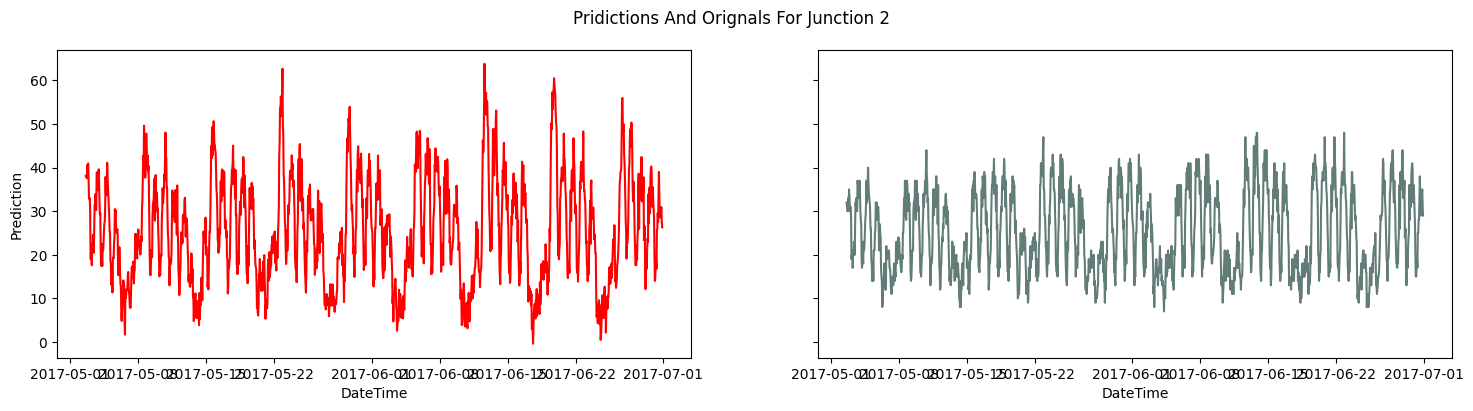

In [ ]:
#Invert the differenced J2
recover2 = df_N2.Norm[-1426:-1].to_frame() #len as per the diff
recover2["Pred"]= PredJ2
Transform_reverssed_J2 = inverse_difference(recover2.Norm, recover2.Pred).to_frame()
Transform_reverssed_J2.columns = ["Pred_Normed"]
Final_J2_Pred = (Transform_reverssed_J2.values* std_J2) + av_J2
Transform_reverssed_J2["Pred_Final"] =Final_J2_Pred
#Plotting the Predictions with orignals
Sub_Plots2(Transform_reverssed_J2["Pred_Final"], df_2[-1426:-1],"Pridictions And Orignals For Junction 2", 1)

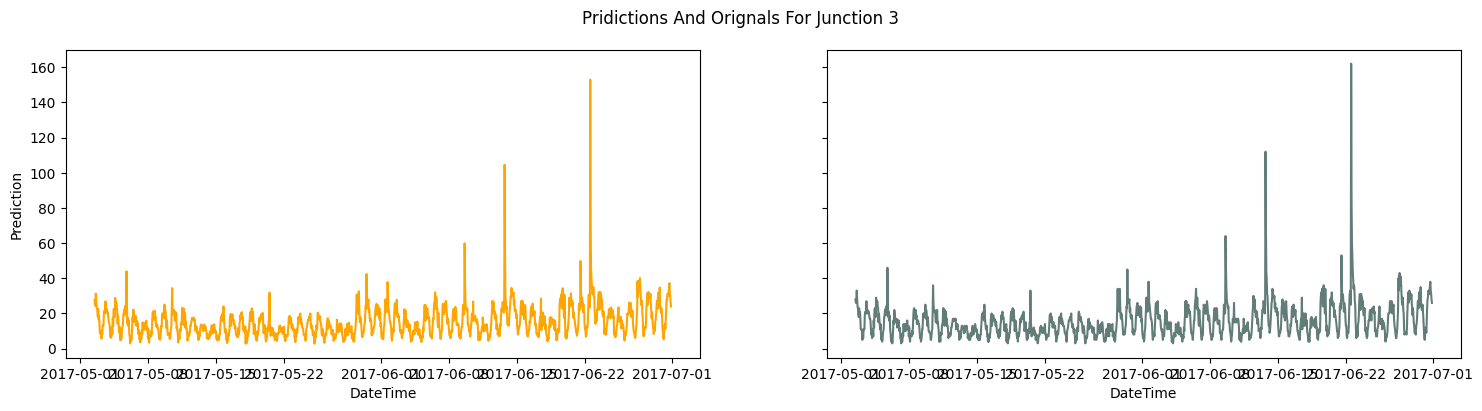

In [ ]:
#Invert the differenced J3
recover3 = df_N3.Norm[-1429:-1].to_frame() #len as per the diff
recover3["Pred"]= PredJ3
Transform_reverssed_J3 = inverse_difference(recover3.Norm, recover3.Pred).to_frame()
Transform_reverssed_J3.columns = ["Pred_Normed"]
#Invert the normalizeation J3
Final_J3_Pred = (Transform_reverssed_J3.values* std_J3) + av_J3
Transform_reverssed_J3["Pred_Final"] =Final_J3_Pred
Sub_Plots2(Transform_reverssed_J3["Pred_Final"], df_3[-1429:-1],"Pridictions And Orignals For Junction 3", 2)

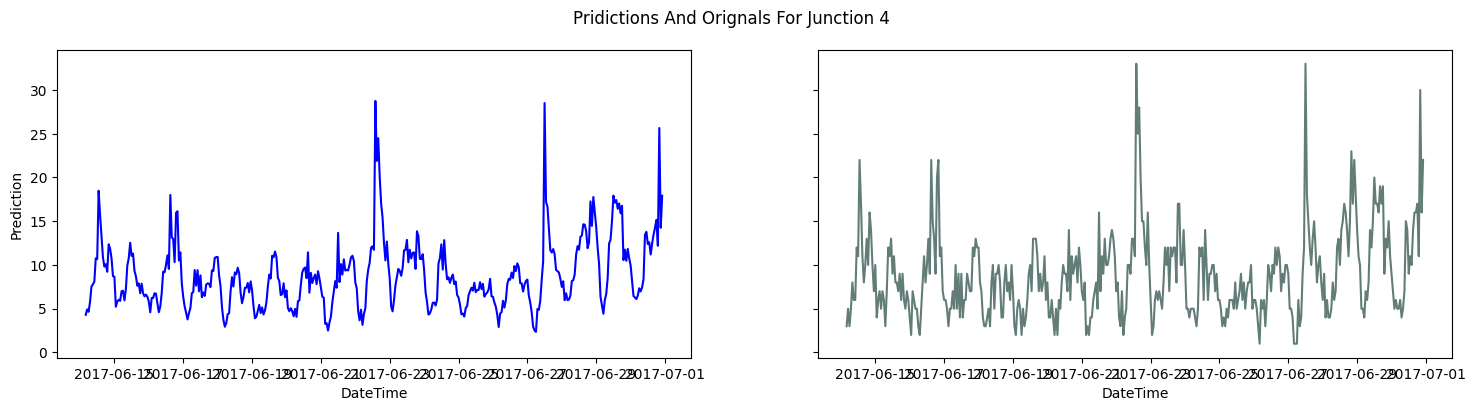

In [ ]:
#Invert the differenced J4
recover4 = df_N4.Norm[-404:-1].to_frame()  #len as per the testset
recover4["Pred"]= PredJ4
Transform_reverssed_J4 = inverse_difference(recover4.Norm, recover4.Pred).to_frame()
Transform_reverssed_J4.columns = ["Pred_Normed"]
#Invert the normalizeation J4
Final_J4_Pred = (Transform_reverssed_J4.values* std_J4) + av_J4
Transform_reverssed_J4["Pred_Final"] =Final_J4_Pred
Sub_Plots2(Transform_reverssed_J4["Pred_Final"], df_4[-404:-1],"Pridictions And Orignals For Junction 4", 3)